# Pathological Gaits Recognition: Data Preprocessing and Exploration

The objective of this notebook is to describe and show the preprocessing steps performed to prepare data for modelling. The same functions are available in Utils>Preprocessing.py.

Section 12 provides a brief data exploration.

## 0 - General Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.subplots as sp
import tensorflow as tf

import os
import sys
import zipfile

from google.colab import drive
from warnings import simplefilter
from math import floor
from itertools import combinations
from scipy.stats import gaussian_kde

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [2]:
with zipfile.ZipFile("Utils.zip", "r") as zip_ref:
  zip_ref.extractall("Utils")
sys.path.append('/content/Utils')

import Utils.Constants as _c

In [3]:
# connect to drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir = '' # data directory, e.g.: '/content/drive/MyDrive/Colab Notebooks/folder/data.zip'
local_data_dir = '' # local data directory, e.g.: '/content/data'

os.chdir('') # change to the directory where the notebook is located, e.g.: '/content/drive/MyDrive/Colab Notebooks/folder'


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

mpl.rcParams['figure.figsize'] = (12, 10)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['legend.fontsize'] = 'large'


## 1 - Create Data Folder

We have a folder with the data organized as follows:

- **12 subjects**, one folder for each subject
- **6 gaits** per subject (including one *normal* gait), one folder for each gait
- **20 trials** per gait, one fodler for each trial
- Each trial contains **2 .csv files**:
  - **Skeleton data**
  - **Foot pressure data**

This results in a total of **1,440 trials** (12 × 6 × 20)

In [6]:
%%capture
!unzip "{data_dir}" -d "{local_data_dir}"


## 2 - Data Augmentation

We applied the following transformations:

- **Skeleton data**: swapped the left and right joints (**swap_left_right_joints** function)
- **Foot pressure data**: flipped the pressure image horizontally (**flip_data** function)

This augmentation **doubles** the dataset size.

---

The augmented files are saved:
- In the **same trial folder** as their original counterparts
- Inside a **new subfolder** named after the original folder **with the suffix `_flipped`**



In [7]:
left_joints = [4,5,6,7,8,9,10,18,19,20,21,28,29]
right_joints = [11,12,13,14,15,16,17,22,23,24,25,30,31]

def swap_left_right_joints(
  data:pd.DataFrame,
  left_joints:list=left_joints,
  right_joints:list=right_joints,
) -> pd.DataFrame:
  """
  This function takes a pd.DataFrame containing skeleton joint coordinates
  (with each joint represented by 3 consecutive columns for x, y, z) and
  swaps the values between corresponding left and right joints (manually inserted based on kinect documentation).
  """
  swapped_data = data.copy()

  for l_joint, r_joint in zip(left_joints, right_joints):
    l_slice = slice(l_joint*3+1, l_joint*3+4) # +1 bc of the first column w time info
    r_slice = slice(r_joint*3+1, r_joint*3+4)

    tmp = swapped_data.iloc[:, l_slice].values
    swapped_data.iloc[:, l_slice] = swapped_data.iloc[:, r_slice].values
    swapped_data.iloc[:, r_slice] = tmp

  return swapped_data

In [8]:
# exemple
data_exemple_orig = pd.read_csv('/content/data/subject1/normal/trial1/skeleton.csv', header=None)
data_exemple_swap = swap_left_right_joints(data_exemple_orig, left_joints, right_joints)

display(data_exemple_orig.head(2))
display(data_exemple_swap.head(2))


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,20200901_11:38:-38.411,0.470502,-0.548209,0.829686,0.468034,-0.524083,1.005471,0.461581,-0.497513,1.144674,0.447222,-0.470484,1.358437,0.421283,-0.492920,1.323787,0.299497,-0.552645,1.281147,0.258252,-0.726487,1.072275,0.208672,-0.723719,0.846988,0.194329,-0.697905,0.755877,0.220170,-0.600243,0.719194,0.220564,-0.626405,0.747822,0.478869,-0.458813,1.322743,0.593999,-0.407851,1.287272,0.706723,-0.399924,1.031018,0.667765,-0.280243,0.834207,0.668838,-0.270633,0.731536,0.656517,-0.355637,0.670031,0.639971,-0.263895,0.714007,0.392954,-0.594936,0.83501,0.238107,-0.598222,0.468174,0.171252,-0.637880,0.095650,0.052279,-0.549407,-0.017217,0.540430,-0.506074,0.824885,0.601201,-0.454553,0.435182,0.725669,-0.53694,0.080781,0.675874,-0.442932,-0.053660,0.435138,-0.449107,1.435887,0.372215,-0.303044,1.420029,0.349735,-0.336314,1.458594,0.338863,-0.460989,1.474002,0.395509,-0.312463,1.464939,0.485646,-0.394901,1.510354,NaN
1,20200901_11:38:-38.455,0.451375,-0.554747,0.826513,0.445435,-0.533280,1.002638,0.435602,-0.507185,1.141795,0.415712,-0.482205,1.355458,0.389940,-0.503105,1.319710,0.266526,-0.555760,1.272479,0.222772,-0.728110,1.062727,0.180183,-0.721660,0.835988,0.173385,-0.710415,0.741075,0.217714,-0.616889,0.711940,0.209832,-0.618771,0.744750,0.448932,-0.471436,1.320899,0.567510,-0.425922,1.289391,0.688551,-0.419294,1.036788,0.659916,-0.290571,0.843829,0.667466,-0.275519,0.742042,0.655039,-0.356725,0.675552,0.635940,-0.265787,0.723045,0.372342,-0.599228,0.82927,0.229193,-0.599070,0.457515,0.159167,-0.629851,0.084566,0.040638,-0.537968,-0.026157,0.522642,-0.514635,0.824028,0.596378,-0.455536,0.437476,0.731433,-0.53260,0.085583,0.687392,-0.436989,-0.049826,0.402116,-0.461287,1.432819,0.354536,-0.309344,1.418102,0.329355,-0.340176,1.457055,0.305755,-0.463116,1.472612,0.377497,-0.321250,1.462616,0.459318,-0.412802,1.506449,NaN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97
0,20200901_11:38:-38.411,0.470502,-0.548209,0.829686,0.468034,-0.524083,1.005471,0.461581,-0.497513,1.144674,0.447222,-0.470484,1.358437,0.478869,-0.458813,1.322743,0.593999,-0.407851,1.287272,0.706723,-0.399924,1.031018,0.667765,-0.280243,0.834207,0.668838,-0.270633,0.731536,0.656517,-0.355637,0.670031,0.639971,-0.263895,0.714007,0.421283,-0.492920,1.323787,0.299497,-0.552645,1.281147,0.258252,-0.726487,1.072275,0.208672,-0.723719,0.846988,0.194329,-0.697905,0.755877,0.220170,-0.600243,0.719194,0.220564,-0.626405,0.747822,0.540430,-0.506074,0.824885,0.601201,-0.454553,0.435182,0.725669,-0.53694,0.080781,0.675874,-0.442932,-0.053660,0.392954,-0.594936,0.83501,0.238107,-0.598222,0.468174,0.171252,-0.637880,0.095650,0.052279,-0.549407,-0.017217,0.435138,-0.449107,1.435887,0.372215,-0.303044,1.420029,0.395509,-0.312463,1.464939,0.485646,-0.394901,1.510354,0.349735,-0.336314,1.458594,0.338863,-0.460989,1.474002,NaN
1,20200901_11:38:-38.455,0.451375,-0.554747,0.826513,0.445435,-0.533280,1.002638,0.435602,-0.507185,1.141795,0.415712,-0.482205,1.355458,0.448932,-0.471436,1.320899,0.567510,-0.425922,1.289391,0.688551,-0.419294,1.036788,0.659916,-0.290571,0.843829,0.667466,-0.275519,0.742042,0.655039,-0.356725,0.675552,0.635940,-0.265787,0.723045,0.389940,-0.503105,1.319710,0.266526,-0.555760,1.272479,0.222772,-0.728110,1.062727,0.180183,-0.721660,0.835988,0.173385,-0.710415,0.741075,0.217714,-0.616889,0.711940,0.209832,-0.618771,0.744750,0.522642,-0.514635,0.824028,0.596378,-0.455536,0.437476,0.731433,-0.53260,0.085583,0.687392,-0.436989,-0.049826,0.372342,-0.599228,0.82927,0.229193,-0.599070,0.457515,0.159167,-0.629851,0.084566,0.040638,-0.537968,-0.026157,0.402116,-0.461287,1.432819,0.354536,-0.309344,1.418102,0.377497,-0.321250,1.462616,0.459318,-0.412802,1.506449,0.329355,-0.340176,1.457055,0.305755,-0.463116,1.472612,NaN


In [9]:
def flip_data(data:pd.DataFrame) -> pd.DataFrame:
  return pd.DataFrame(np.fliplr(data))

In [10]:
# exemple
data_exemple_orig = pd.read_csv('/content/data/subject1/normal/trial1/pressure.csv', header=None)
data_exemple_swap = flip_data(data_exemple_orig)

display(data_exemple_orig.iloc[38:40,:])
print('\n')
display(data_exemple_swap.iloc[38:40,:])


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,9,12,13,13,11,6,2,0,0,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,6,10,12,13,10,6,2,1,0,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
38,0,0,0,0,0,0,0,0,0,0,0,0,2,6,11,13,13,12,9,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,0,1,2,6,10,13,12,10,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3 - Create Labels

We create a `pandas.DataFrame` called `reference_df` that organizes and processes the dataset as follows:

1. **Iterate through each subject**, gait type, and trial.
2. For each trial:
   - Load the corresponding **skeleton data** and **foot pressure data** from their file paths.
   - Apply data augmentation:
     - **Skeleton data**: swap left and right joints.
     - **Foot pressure data**: flip the image along the y-axis.
   - Save the augmented versions of the files inside a **new subfolder** named after the original trial folder with the suffix `_flipped`.

3. In `reference_df`, each row represents one trial (original or augmented), and includes:
   - The file paths to the **skeleton data** and **pressure data** as index.
   - A **subject** column identifying which subject the trial belongs to.
   - A **label** column that encodes the **gait type** as a numeric value.

The final `reference_df` serves as a comprehensive reference for both original and augmented data.


In [11]:
def create_reference_df(
  base_dir:str='/content/data',
  convrt_gait_dict:dict=_c.convrt_gait_dict
) -> pd.DataFrame:

  reference_df = pd.DataFrame(columns=['label', 'subject'])

  for subject in os.listdir(base_dir): # for each subject
    subject_dir = os.path.join(base_dir, subject)

    if not os.path.isdir(subject_dir):
      continue

    for gait in os.listdir(subject_dir): # for each gait
      gait_dir = os.path.join(subject_dir, gait)
      if not os.path.isdir(gait_dir):
        continue

      for trial in os.listdir(gait_dir): # for each trial
        trial_dir = os.path.join(gait_dir, trial)
        if not os.path.isdir(trial_dir):
          continue

        sk_data_path = os.path.join(trial_dir, 'skeleton.csv')
        ft_data_path = os.path.join(trial_dir, 'pressure.csv')
        if (not os.path.isfile(sk_data_path)) | (not os.path.isfile(ft_data_path)):
          continue

        reference_df.loc[trial_dir] = [convrt_gait_dict[gait], subject]

        # Data Augmentation
        flipped_data_sk = pd.read_csv(sk_data_path, header=None)
        flipped_data_sk = swap_left_right_joints(flipped_data_sk)

        flipped_data_ft = pd.read_csv(ft_data_path, header=None)
        flipped_data_ft = flip_data(flipped_data_ft)

        # save data into a new folder
        flipped_trial_dir = trial_dir + '_flipped'
        os.makedirs(flipped_trial_dir, exist_ok=True)

        flipped_data_sk.to_csv(os.path.join(flipped_trial_dir, 'skeleton.csv'), index=False, header=False)
        flipped_data_ft.to_csv(os.path.join(flipped_trial_dir, 'pressure.csv'), index=False, header=False)

        reference_df.loc[flipped_trial_dir] = [convrt_gait_dict[gait], subject]

  return reference_df


In [12]:
reference_df = create_reference_df(local_data_dir)

print(f'{reference_df.shape=}')
reference_df.head()


reference_df.shape=(2880, 2)


,label,subject
/content/data/subject3/trendelenburg/trial9,5,subject3
/content/data/subject3/trendelenburg/trial9_flipped,5,subject3
/content/data/subject3/trendelenburg/trial10,5,subject3
/content/data/subject3/trendelenburg/trial10_flipped,5,subject3
/content/data/subject3/trendelenburg/trial15,5,subject3


## 4 - Create a Validation Set

To demonstrate all preprocessing steps in preparation for a **Leave-One-Subject-Out Cross-Validation (LOSO-CV)** strategy, we exclude Subject 12 from the training set while using only its data f as the validation set.

This means:
- The **training set** consists of all trials (original and augmented) from Subjects 1 to 11.
- The **validation set** consists of all trials (original) from Subject 12.

This setup helps evaluate the model’s ability to generalize to unseen subjects and it's suitable when dealing with small datasets.


In [23]:
train_reference_df = reference_df[reference_df['subject']!='subject12']

valid_reference_df = reference_df[reference_df['subject']=='subject12']
valid_reference_df = valid_reference_df[~valid_reference_df.index.str.contains('flipped')] # remove data augmentation for validation set

print(train_reference_df['subject'].value_counts().to_string(), '\n')
print(valid_reference_df['subject'].value_counts().to_string())


subject
subject3     240
subject11    240
subject6     240
subject5     240
subject8     240
subject2     240
subject10    240
subject4     240
subject7     240
subject9     240
subject1     240 

subject
subject12    120


## 5 - Load Data

***Data Loading, Cleaning, and Augmentation Verification***

In this section, we demonstrate the **data loading**, **cleaning**, and **augmentation validation** steps for both **skeleton**, **speed** and **foot pressure** data.

---

***Skeleton Data***

We use the function `load_data_sk` to:

1. **Load** the `skeleton.csv` file from a given trial directory.
2. Optionally **clean** the data by:
   - Removing frames where the time difference between samples is zero.
   - Dropping the time (1st column) and NA (last column) columns.
3. **Reshape** the data from 2D to 3D: `(frames, joints, coordinates)`.

---

***Speed Computation***

Using `load_data_speed`, we:

1. Load and clean the skeleton data.
2. Compute **temporal steps** between frames.
3. Compute **spatial steps** by calculating Euclidean distances between joint positions frame-to-frame.
4. Compute **speed** as spatial delta divided by temporal delta.

---

***Foot Pressure Data***

With `load_data_ft` we simply load the `pressure.csv` file.

---


In [17]:
def compute_time_steps(data:pd.DataFrame):
  """
  Compute time deltas between frames, removing rows with zero time delta.
  Main steps:
  - pick time column (the first one) and convert to time object
  - compute the difference between each step and the sequential one
  - remove rows with time delta = 0
  - return cleaned data and time deltas
  """
  times = data[data.columns[0]].astype(str)
  times = times.apply(lambda x: x.replace('-', ''))
  times = pd.to_datetime(times, format='%Y%m%d_%H:%M:%S.%f')

  times_deltas = times.diff().dropna()
  times_deltas = times_deltas.dt.total_seconds()

  rows_to_drop = np.where(times_deltas.to_numpy() == 0)[0] + 1
  data = data.drop(index=rows_to_drop)

  times_deltas = times_deltas[times_deltas!=0]
  times_deltas = np.expand_dims(times_deltas, axis=1)

  return data, times_deltas

def compute_space_steps(data:pd.DataFrame):
  """
  Compute spatial deltas between joint positions frame-to-frame.
  Main steps:
  - drop time and NA columns
  - reshape data to (frames, joints, coordinates)
  - compute euclidean distance (between each frame and the sequential one)
  - return spatial deltas
  """
  data = data.drop([data.columns[0], data.columns[-1]], axis=1).copy()
  all_joints_position = data.to_numpy()

  num_joints = int(data.shape[1] / 3)
  all_joints_position = all_joints_position.reshape(-1, num_joints, 3)

  space_deltas = np.diff(all_joints_position, axis=0)
  space_deltas = np.linalg.norm(space_deltas, axis=2)

  return space_deltas


### 5.1 - Load Skeleton Data

In [18]:
def load_data_sk(
  data_dir:str=None,
  clean_data:bool=True,
):

  if isinstance(data_dir, bytes):
    data_dir = data_dir.decode()

  # load the csv file
  data = pd.read_csv(os.path.join(data_dir, 'skeleton.csv'), header=None)

  # remove rows with time diff = 0
  if clean_data:
    data, _ = compute_time_steps(data)

  # drop time and NA (last) columns
  data = data.drop([data.columns[0], data.columns[-1]], axis=1)

  # reshape data
  num_joints = int(data.shape[1] / 3)
  data = data.to_numpy().reshape((-1, num_joints, 3))

  # remove last row to match speed data size
  if clean_data:
    return data.squeeze()[:-1]
  else:
    return data.squeeze()


In [19]:
skeleton_exemple = load_data_sk('/content/data/subject1/normal/trial1', clean_data=False)
skeleton_exemple_clean = load_data_sk('/content/data/subject1/normal/trial1', clean_data=True)

print(f"{skeleton_exemple.shape=}")
print(f"{skeleton_exemple_clean.shape=}")


skeleton_exemple.shape=(200, 32, 3)
skeleton_exemple_clean.shape=(170, 32, 3)


### 5.2 - Load Speed Data

In [20]:
def load_data_speed(
  data_dir:str=None
):

  if isinstance(data_dir, bytes):
    data_dir = data_dir.decode()

  data = pd.read_csv(os.path.join(data_dir, 'skeleton.csv'), header=None)

  # compute the difference in time between two consecutive frames
  data, times_deltas = compute_time_steps(data)

  # perform the same of above for the spatial dimension
  space_deltas = compute_space_steps(data)

  # compute the speed
  speed = space_deltas / times_deltas

  return speed


In [21]:
speed_exemple = load_data_speed('/content/data/subject1/normal/trial1')
speed_exemple_flip = load_data_speed('/content/data/subject1/normal/trial1_flipped')

print(f"{speed_exemple.shape=}")
print(f"{speed_exemple_flip.shape=}")
print(f"Are the arrays equal? {np.allclose(speed_exemple, speed_exemple_flip)}")


speed_exemple.shape=(170, 32)
speed_exemple_flip.shape=(170, 32)
Are the arrays equal? False


### 5.3 Load Foot Pressure Data

In [22]:
def load_data_ft(
  data_dir:str=None,
):

  if isinstance(data_dir, bytes):
    data_dir = data_dir.decode()

  data = pd.read_csv(os.path.join(data_dir, 'pressure.csv'), header=None).to_numpy()

  return data.squeeze()

foot_exemple.shape=(128, 48)
foot_exemple_flip.shape=(128, 48)
Original data shapes: (128, 48)
Flipped data shapes: (128, 48)
Flipped correctly: True


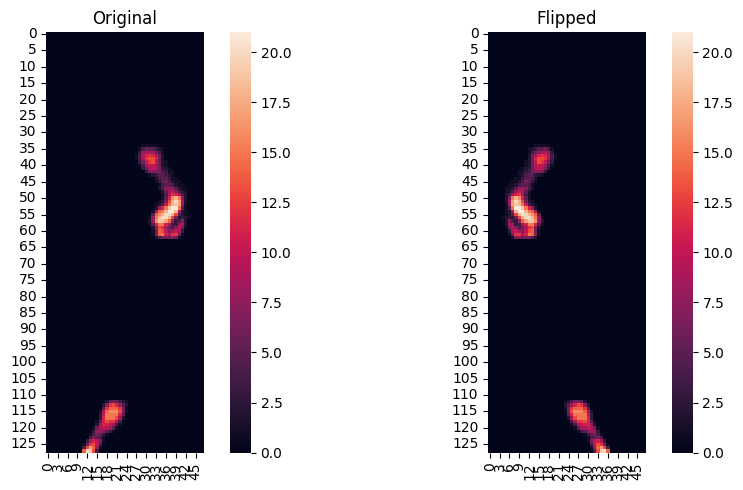

In [23]:
foot_exemple = load_data_ft('/content/data/subject1/normal/trial1')
foot_exemple_flip = load_data_ft('/content/data/subject1/normal/trial1_flipped')

print(f"{foot_exemple.shape=}")
print(f"{foot_exemple_flip.shape=}")

print('Original data shapes: {}'.format(foot_exemple.shape))
print('Flipped data shapes: {}'.format(foot_exemple_flip.shape))
print('Flipped correctly: {}'.format(np.array_equal(foot_exemple, np.fliplr(foot_exemple_flip))))

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(foot_exemple, square=True, ax=axs[0])
axs[0].set_title('Original')
sns.heatmap(foot_exemple_flip, square=True, ax=axs[1])
axs[1].set_title('Flipped')
plt.tight_layout()
plt.show()


## 6 - Keep Only Some Joints

As suggested in many related works, we define a function to **exclude certain joints** from the skeleton-based data. This preprocessing step is crucial because some joints (e.g. eyes, ears and others) may contribute more **noise than useful signal**, removing them can improve **model performance**.

We apply this joint selection to both:
- **Skeleton data** (3 columns `x, y, z` related to each joint)
- **Speed data** (1 column related to each joint)

In [24]:
joints_to_include = [0,1,2,3,4,11,18,19,20,21,22,23,24,25]

def remove_joints(data, joints_to_include, is_speed:bool=False):
  return data[:, joints_to_include] if is_speed else data[:, joints_to_include, :]


In [25]:
skeleton_exemple_joints = remove_joints(data=skeleton_exemple, joints_to_include=joints_to_include, is_speed=False)
speed_exemple_joints = remove_joints(data=speed_exemple, joints_to_include=joints_to_include, is_speed=True)

print(f"Original skeleton shape: {skeleton_exemple.shape}")
print(f"New skeleton shape: {skeleton_exemple_joints.shape}\n")
print(f"Original speed shape: {speed_exemple.shape}")
print(f"New speed shape: {speed_exemple_joints.shape}")


Original skeleton shape: (200, 32, 3)
New skeleton shape: (200, 14, 3)

Original speed shape: (170, 32)
New speed shape: (170, 14)


## 7 - Normalize Data


***Data Normalization***

We normalize all input data to improve model training and stability:

- **Skeleton data** (`norm_data_sk`):  
  Normalize x, y, z coordinates using 5th–95th percentiles (per axis) of the entire column in the same trial exemple.

- **Speed data** (`norm_speed`):  
  Normalize each joint using the 5th and 95th percentiles of the entire column in the same trial exemple.

- **Foot pressure data** (`norm_data_ft`):  
  Normalize by dividing all pixel values by 255 such that the values are in [0, 1].


### 7.1 - Normalize Skeleton Data

In [26]:
def norm_data_sk(data):

  norm_factor_x = np.percentile(data[:, :, 0], 95) - np.percentile(data[:, :, 0], 5)
  norm_factor_y = np.percentile(data[:, :, 1], 95) - np.percentile(data[:, :, 1], 5)
  norm_factor_z = np.percentile(data[:, :, 2], 95) - np.percentile(data[:, :, 2], 5)

  data_norm = data.copy()

  data_norm[:, :, 0] = (data[:, :, 0] - np.percentile(data[:, :, 0], 5)) / norm_factor_x
  data_norm[:, :, 1] = (data[:, :, 1] - np.percentile(data[:, :, 1], 5)) / norm_factor_y
  data_norm[:, :, 2] = (data[:, :, 2] - np.percentile(data[:, :, 2], 5)) / norm_factor_z

  return data_norm


In [27]:
skeleton_exemple_norm = norm_data_sk(data=skeleton_exemple_joints)

print(f"Original skeleton shape: {skeleton_exemple_joints.shape}")
print(f"Normalized skeleton shape: {skeleton_exemple_norm.shape}\n")

for i in range(2):
  print(f'\t\t=== Time step {i+1} ===')
  print('Original\n', skeleton_exemple_joints[i])
  print('Normalized\n', skeleton_exemple_norm[i], '\n')


Original skeleton shape: (200, 14, 3)
Normalized skeleton shape: (200, 14, 3)

		=== Time step 1 ===
Original
 [[ 0.470502 -0.548209  0.829686]
 [ 0.468034 -0.524083  1.005471]
 [ 0.461581 -0.497513  1.144674]
 [ 0.447222 -0.470484  1.358437]
 [ 0.421283 -0.49292   1.323787]
 [ 0.478869 -0.458813  1.322743]
 [ 0.392954 -0.594936  0.83501 ]
 [ 0.238107 -0.598222  0.468174]
 [ 0.171252 -0.63788   0.09565 ]
 [ 0.052279 -0.549407 -0.017217]
 [ 0.54043  -0.506074  0.824885]
 [ 0.601201 -0.454553  0.435182]
 [ 0.725669 -0.53694   0.080781]
 [ 0.675874 -0.442932 -0.05366 ]]
Normalized
 [[ 1.60998200e+00  1.64983130e-02  5.99601202e-01]
 [ 1.60302541e+00  2.54356031e-02  7.21519096e-01]
 [ 1.58483625e+00  3.52782540e-02  8.18065085e-01]
 [ 1.54436233e+00  4.52909379e-02  9.66323099e-01]
 [ 1.47124771e+00  3.69796953e-02  9.42291156e-01]
 [ 1.63356618e+00  4.96143696e-02  9.41567077e-01]
 [ 1.39139635e+00 -8.11342646e-04  6.03293729e-01]
 [ 9.54926929e-01 -2.02861592e-03  3.48870013e-01]
 [ 7.6

### 7.2 - Normalize Speed Data

In [28]:
def norm_speed(speed):

  speed_5th_percentile = np.percentile(speed, 5, axis=0)
  speed_95th_percentile = np.percentile(speed, 95, axis=0)

  speed_norm = (speed - speed_5th_percentile) / (speed_95th_percentile - speed_5th_percentile)

  return speed_norm


In [29]:
speed_norm = norm_speed(speed_exemple_joints)

print(f"Original speed shape: {speed_exemple_joints.shape}")
print(f"Normalized speed shape: {speed_norm.shape}\n")

for i in range(2):
  print(f'\t\t=== Time step {i+1} ===')
  print('Original\n', speed_exemple_joints[i])
  print('Normalized\n', speed_norm[i], '\n')


Original speed shape: (170, 14)
Normalized speed shape: (170, 14)

		=== Time step 1 ===
Original
 [0.46502438 0.55824284 0.63341226 0.76707033 0.75471651 0.73958486
 0.4959669  0.31638517 0.41496236 0.42292713 0.4490797  0.12341988
 0.19697938 0.30718255]
Normalized
 [0.21272036 0.27241734 0.31797479 0.3962375  0.38827169 0.37861911
 0.22111978 0.12835926 0.16358046 0.13327737 0.19744533 0.04169686
 0.06408715 0.09152825] 

		=== Time step 2 ===
Original
 [1.36261741 1.52972926 1.66967337 1.85720784 1.82717708 1.82416961
 1.38660298 0.9636202  0.70900388 0.72052736 1.34794058 0.77275212
 0.65354881 0.90042358]
Normalized
 [0.63695966 0.75877168 0.85543902 0.98108027 0.96185987 0.95664724
 0.63264499 0.4135711  0.29156382 0.23660595 0.60569944 0.3329807
 0.24635584 0.29462682] 



### 7.1 - Normalize Foot Pressure Data

In [30]:
def norm_data_ft(data):
  data_norm = data/255.
  return data_norm


Original speed shape: (128, 48)
Normalized speed shape: (128, 48)



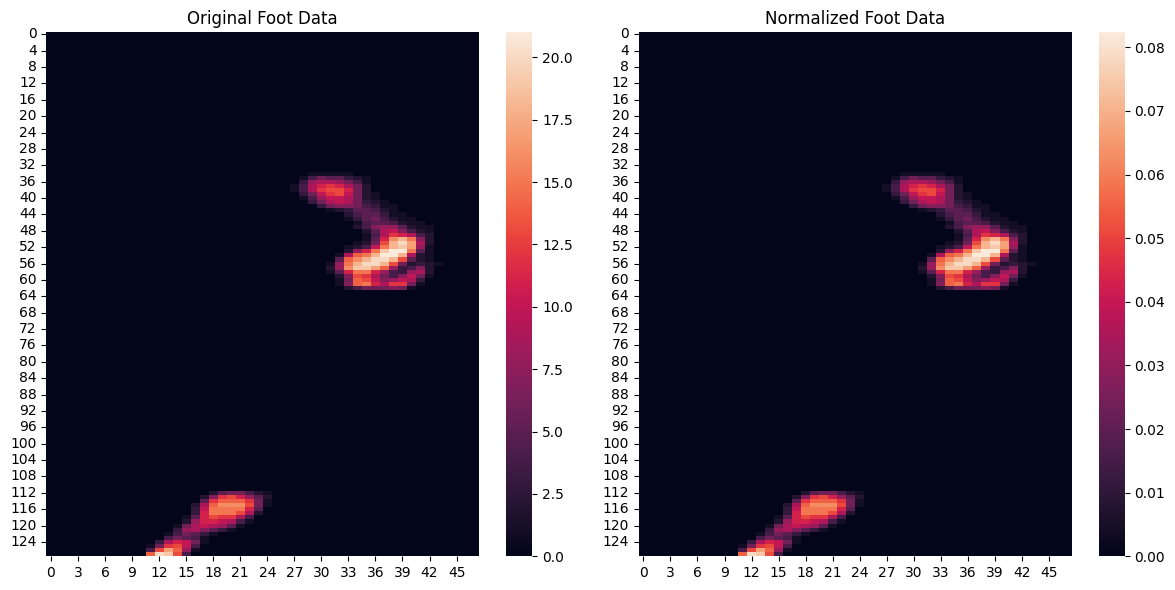

In [31]:
foot_norm = norm_data_ft(foot_exemple)

print(f"Original speed shape: {foot_exemple.shape}")
print(f"Normalized speed shape: {foot_norm.shape}\n")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(foot_exemple, ax=axes[0])
axes[0].set_title('Original Foot Data')
sns.heatmap(foot_norm, ax=axes[1])
axes[1].set_title('Normalized Foot Data')
plt.tight_layout()
plt.show()


## 8 - Crop Skeleton and Speed Data

***Temporal Cropping***

To standardize input sequence lengths, we apply a temporal cropping strategy via the `crop_data` function.
This is applied consistently to both **skeleton** and **speed** data to ensure alignment. The random crop do not consider the same indexes for both skeleton and speed data (due to its randomic behaviour) but since the center_crop demostrated better performances wrt random_crop, we didn't implement it but keep it in the function because can be still useful for single model tries (like just considering skeleton data).


In [32]:
def crop_data(
  data:np.ndarray,
  target_size:int=50,
  crop_type:str='aggressive_center'
):
  '''
  Crops a sequence of data to a fixed length.
  '''
  if isinstance(crop_type, bytes):
    crop_type = crop_type.decode('utf-8')

  if crop_type=='top':
    data_crop = data[10:int(10+target_size)]

  elif crop_type=='bottom':
    data_without_noise = data[:-25, :]
    if data_without_noise.shape[0] < target_size:
      data_crop = data[-target_size:, :]
    else:
      data_crop = data_without_noise[-target_size:, :]

  elif crop_type=='40perc':
    numb40perc = int(data.shape[0] * 0.4)
    data_without_noise = data[numb40perc:, :]
    if data_without_noise.shape[0] < target_size:
      data_crop = data[-target_size:, :]
    else:
      data_crop = data_without_noise[:target_size, :]

  else: # center or random

    if 'aggressive' in crop_type:
      initial_noise, final_noise = int(data.shape[0]/2) - 20, 10

    else:
      initial_noise, final_noise = 10, 5

    start, end = initial_noise, data.shape[0] - final_noise

    data_without_noise = data[start:end, :]
    N = data_without_noise.shape[0]

    if 'center' in crop_type: # center crop
      initial_step = int((N / 2) - (target_size / 2))
    else: # random crop
      initial_step = np.random.randint(0, np.floor(N - target_size))

    data_crop = data_without_noise[initial_step:initial_step+target_size]

  if data_crop.shape[0]!=target_size:
    raise ValueError(f"Output data length is {data_crop.shape[0]} != {target_size=}")

  return data_crop


In [33]:
skeleton_crop = crop_data(skeleton_exemple_norm, target_size=50, crop_type='aggressive_center')
print(f"Original skeleton shape: {skeleton_exemple_norm.shape}")
print(f"New skeleton shape: {skeleton_crop.shape}\n")

speed_crop = crop_data(speed_norm, target_size=50, crop_type='aggressive_center')
print(f"Original speed shape: {speed_norm.shape}")
print(f"New speed shape: {speed_crop.shape}")


Original skeleton shape: (200, 14, 3)
New skeleton shape: (50, 14, 3)

Original speed shape: (170, 14)
New speed shape: (50, 14)


Other scenario concers evicting all subsequences discarding some inital and final noise steps

In [34]:
def extract_subseq(data, target_size:int):

  noise_time_begin = int(0.4*data.shape[0])
  noise_time_end = 10
  start = noise_time_begin
  end = data.shape[0] - noise_time_end
  data_crop = data[start:end, :]

  N = data_crop.shape[0]

  if target_size > N:
    raise ValueError(f"Target size {target_size} is larger than the cropped data size {N}")

  chunks = []
  for i in range(0, N - target_size + 1, target_size):
    chunks.append(data_crop[i:i + target_size])

  return np.stack(chunks).astype(np.float32)

In [35]:
subseq_sk = extract_subseq(skeleton_exemple_norm, 50)
print(f"Original skeleton shape: {skeleton_exemple_norm.shape}")
print(f"New skeleton shape: {subseq_sk.shape}\n")
for i in range(len(subseq_sk)):
  print(f'\t\t\t=== Subsequence {i+1} ===')
  print(subseq_sk[i], '\n')


Original skeleton shape: (200, 14, 3)
New skeleton shape: (2, 50, 14, 3)

			=== Subsequence 1 ===
[[[ 3.16702396e-01  2.35444959e-02  6.29306495e-01]
  [ 3.31227243e-01  2.80638915e-02  7.53929973e-01]
  [ 3.41298491e-01  2.90188920e-02  8.53783548e-01]
  ...
  [ 5.52042484e-01  3.53790149e-02  3.49119693e-01]
  [ 4.93359685e-01  1.24138165e-02  8.21424946e-02]
  [ 5.46796858e-01  5.89513667e-02 -3.83817533e-04]]

 [[ 3.13773751e-01  2.29910538e-02  6.29092872e-01]
  [ 3.29333067e-01  2.73859818e-02  7.53783643e-01]
  [ 3.39782029e-01  2.84435935e-02  8.53678107e-01]
  ...
  [ 5.50506294e-01  3.45392227e-02  3.48883182e-01]
  [ 4.90400016e-01  1.09772412e-02  8.19767341e-02]
  [ 5.49328089e-01  5.84186725e-02  1.42013875e-03]]

 [[ 3.14193755e-01  2.39090100e-02  6.28853619e-01]
  [ 3.28287303e-01  2.79779490e-02  7.53589451e-01]
  [ 3.37851226e-01  2.88514514e-02  8.53492975e-01]
  ...
  [ 5.46114743e-01  3.53312269e-02  3.48650843e-01]
  [ 4.85892892e-01  1.15603181e-02  8.18206817e

## 9 - Center Foot Pressure Data

***Centering Foot Pressure Data***

The `baricenter` function shifts the foot pressure data such that the **barycenter (weighted average)** of the data is aligned with the center of the matrix:

- **Barycenter Calculation**: Computes the weighted average position (center of mass) along both the x and y dimensions based on the pressure values.
- **Shifting**: The data is then shifted so that the barycenter aligns with the center of the matrix using `np.roll` for both dimensions.


In [36]:
def baricenter(data):
  # Compute the weighted average (barycenter) along each dimension
  y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
  x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))

  # Compute the distances between each point and the barycenter
  shift_x = -(x_barycenter - data.shape[1]/2)
  shift_y = -(y_barycenter - data.shape[0]/2)

  # Shift the foot pressure matrix to be centered on the barycenter
  shifted_data = np.roll(data, int(shift_x), axis=1)
  shifted_data = np.roll(shifted_data, int(shift_y), axis=0)

  return shifted_data


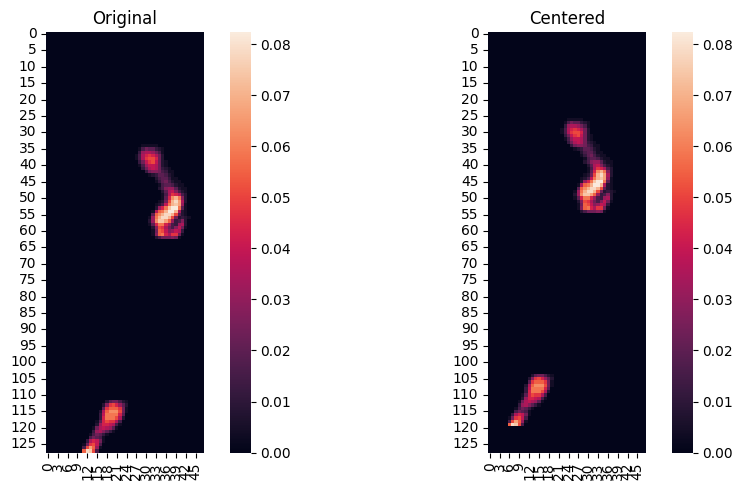

In [37]:
foot_centered = baricenter(foot_norm)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.heatmap(foot_norm, square=True, ax=axes[0])
axes[0].set_title('Original')
sns.heatmap(foot_centered, square=True, ax=axes[1])
axes[1].set_title('Centered')
plt.tight_layout()
plt.show()


## 10 - Load and Preprocess

We will now define a function for each data type to load and preprocess a single exemple

In [38]:
def load_and_preprocess_data_sk(path:str, joints:list=list(range(0,32)), clean_data:bool=True, norm:bool=True):

  data = load_data_sk(path, clean_data)

  data = remove_joints(data, joints)

  if norm:
    data = norm_data_sk(data)

  data = data.reshape(len(data),-1)

  return data.astype(np.float32)


In [39]:
skeleton_preprocess = load_and_preprocess_data_sk(path='/content/data/subject1/normal/trial1',
                                                  joints=joints_to_include,
                                                  clean_data=True, norm=True)

print(f"{skeleton_preprocess.shape=}\n")
for i in range(2):
  print(f'\t\t\t=== Time step {i+1} ===')
  print(skeleton_preprocess[i], '\n')


skeleton_preprocess.shape=(170, 42)

			=== Time step 1 ===
[ 1.5930920e+00  1.6884919e-02  5.9988266e-01  1.5862086e+00
  2.6049869e-02  7.2179610e-01  1.5682108e+00  3.6143243e-02
  8.1833851e-01  1.5281628e+00  4.6410982e-02  9.6659106e-01
  1.4558176e+00  3.7888024e-02  9.4255996e-01  1.6164279e+00
  5.0844543e-02  9.4183594e-01  1.3768065e+00 -8.6566730e-04
  6.0357505e-01  9.4493032e-01 -2.1139483e-03  3.4916073e-01
  7.5846827e-01 -1.7179172e-02  9.0801574e-02  4.2664647e-01
  1.6429825e-02  1.2524134e-02  1.7881247e+00  3.2891102e-02
  5.9655303e-01  1.9576181e+00  5.2462827e-02  3.2627955e-01
  2.3047657e+00  2.1165771e-02  8.0489367e-02  2.1658850e+00
  5.6877397e-02 -1.2750435e-02] 

			=== Time step 2 ===
[ 1.5397457   0.01440127  0.59768206  1.5231788   0.02255613  0.7198313
  1.495754    0.03246906  0.8163418   1.4402798   0.04195843  0.964525
  1.3684003   0.03401896  0.93973243  1.532932    0.04604934  0.94055706
  1.3193187  -0.00249611  0.5995942   0.92006874 -0.00243

In [40]:
def load_and_preprocess_speed(path:str, joints:list=None, norm:bool=True):

  data = load_data_speed(path)

  data = remove_joints(data, joints, is_speed=True)

  if norm:
    data = norm_speed(data)

  data = data.reshape(len(data),-1)

  return data.astype(np.float32)


In [41]:
speed_preprocess = load_and_preprocess_speed(path='/content/data/subject1/normal/trial1',
                                             joints=joints_to_include,
                                             norm=True)

print(f"{speed_preprocess.shape=}\n")
for i in range(2):
  print(f'\t\t\t=== Time step {i+1} ===')
  print(speed_preprocess[i], '\n')


speed_preprocess.shape=(170, 14)

			=== Time step 1 ===
[0.21272035 0.27241734 0.3179748  0.3962375  0.3882717  0.3786191
 0.22111978 0.12835926 0.16358046 0.13327737 0.19744533 0.04169686
 0.06408715 0.09152825] 

			=== Time step 2 ===
[0.6369597  0.75877166 0.855439   0.9810803  0.9618599  0.9566472
 0.632645   0.4135711  0.2915638  0.23660596 0.6056994  0.3329807
 0.24635585 0.29462683] 



In [42]:
def load_and_preprocess_data_ft(path:str, norm:bool=True, center:bool=True):

  data = load_data_ft(path)

  if norm:
    data = norm_data_ft(data)

  if center:
    data = baricenter(data)

  return data.astype(np.float32)


foot_preprocess.shape=(128, 48)



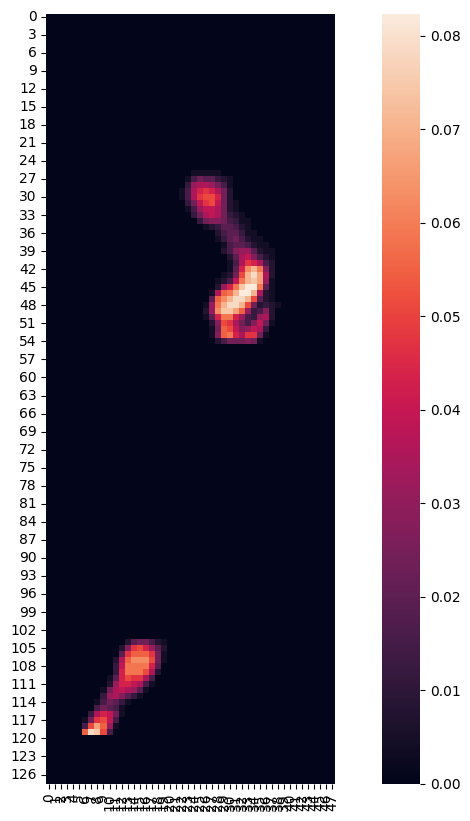

In [43]:
foot_preprocess = load_and_preprocess_data_ft(path='/content/data/subject1/normal/trial1',
                                              norm=True,
                                              center=True)

print(f"{foot_preprocess.shape=}\n")
sns.heatmap(foot_preprocess, square=True)
plt.show()


## 11 - Dataset Definition

### 11.1 - Single Classifier

In [ ]:
def create_dataset(
  reference_df:pd.DataFrame,
  data_type:str='skeleton',
  joints:list=list(range(0,32)),
  target_size:int=50,
  img_size:tuple=(128,48,1),
  clean_data:bool=True,
  norm:bool=True,
  crop_type:str=None,
  center_ft:bool=True,
  shuffle:bool=True,
  cache_file:str=None,
  batch_size:int=30,
):

  assert data_type in ('skeleton', 'speed', 'foot'), f"Invalid data_type: {data_type}"
  if data_type!='foot':
    assert crop_type in ('top', 'bottom', '40perc', 'aggressive_center', 'aggressive_random', 'center', 'random', 'split_subsequence'), f"Invalid crop_type: {crop_type}"

  file_paths = list(reference_df.index)
  labels = reference_df['label']
  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

  ############################
  # LOAD AND PREPROCESS DATA #
  ############################
  if data_type=='skeleton':
    input_size = (target_size, len(joints)*3)
    py_func0 =  lambda file_path, label: (tf.numpy_function(load_and_preprocess_data_sk, [file_path, joints, clean_data, norm],
                                                           tf.float32), label)

  elif data_type=='speed':
    input_size = (target_size, len(joints))
    py_func0 =  lambda file_path, label: (tf.numpy_function(load_and_preprocess_speed, [file_path, joints, norm],
                                                           tf.float32), label)
  else: # data_type=='foot'
    input_size = img_size
    py_func0 =  lambda file_path, label: (tf.numpy_function(load_and_preprocess_data_ft, [file_path, norm, center_ft],
                                                           tf.float32), label)

  dataset = dataset.map(py_func0, num_parallel_calls=os.cpu_count())

  ########################################
  # SPLIT IN SUBSEQ OR ADJUST DIMENSIONS #
  ########################################
  if (data_type in ('skeleton', 'speed')) and (crop_type=='split_subsequence'):

    def map_and_split(data, label):
      def crop_wrapper(d):
        return extract_subseq(d, target_size)

      chunks = tf.py_function(func=crop_wrapper, inp=[data], Tout=tf.float32)
      chunks.set_shape([None, target_size, input_size[-1]])  # e.g.: (None, 50, 96)

      labels = tf.repeat(tf.expand_dims(label, 0), tf.shape(chunks)[0])
      return tf.data.Dataset.from_tensor_slices((chunks, labels))

    dataset = dataset.flat_map(map_and_split)

  if data_type=='foot':
    dataset = dataset.map(lambda data, label: (tf.expand_dims(data, 2), label)) # input shape (128,48) --> (128,48,1)
    py_func1 = lambda data, label: (tf.ensure_shape(data, input_size), label)
    dataset = dataset.map(py_func1, num_parallel_calls=os.cpu_count())

  # cache
  if cache_file:
    dataset = dataset.cache(cache_file)

  # shuffle
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(file_paths))

  # repeat
  dataset = dataset.repeat()

  ########
  # CROP #
  ########
  if (data_type in ('skeleton', 'speed')) and (crop_type!='split_subsequence'):

    py_func1 = lambda data, label: (tf.ensure_shape(tf.numpy_function(crop_data, [data, target_size, crop_type],
                                                    tf.float32), input_size), label)
    dataset = dataset.map(py_func1, num_parallel_calls=os.cpu_count())

  # batch
  dataset = dataset.batch(batch_size)

  # prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset


Let's visualize some exemples for each data type (skeleton, speed and foot pressure)

In [ ]:
train_sk_exemple = create_dataset(reference_df=train_reference_df,
                                  data_type='skeleton',
                                  crop_type='split_subsequence')

for batch_data, batch_labels in train_sk_exemple.take(1):

  batch_data_np = batch_data.numpy()
  batch_labels_np = batch_labels.numpy()

  for i in range(2):
    print(f"\n\t\t\t\t=== Example {i+1} ===")
    print("Data:\n", batch_data_np[i])
    print(f"Data shape: {batch_data_np[i].shape}")
    print(f"Label: {batch_labels_np[i]}")



				=== Example 1 ===
Data:
 [[0.48631528 0.4594126  0.53782797 ... 0.5676083  0.3598266  0.9508701 ]
 [0.4887409  0.4667286  0.53754056 ... 0.57983893 0.35858312 0.93526655]
 [0.48877376 0.47400698 0.5355979  ... 0.55832946 0.35611352 0.93401116]
 ...
 [0.51085    0.7595653  0.5423426  ... 0.57083476 0.7085781  0.9898425 ]
 [0.5171268  0.7716198  0.54331255 ... 0.5404487  0.7055225  0.9893927 ]
 [0.5200921  0.7773953  0.54168326 ... 0.5341777  0.7078217  0.98594123]]
Data shape: (50, 96)
Label: 3

				=== Example 2 ===
Data:
 [[0.44919413 0.11173027 0.56062883 ... 0.3055869  0.1195142  1.0056696 ]
 [0.44791505 0.11169785 0.5617278  ... 0.3088552  0.11788154 1.0065069 ]
 [0.44751465 0.11172666 0.5623288  ... 0.3082989  0.11668845 1.0062487 ]
 ...
 [0.5403884  0.4339797  0.5542033  ... 0.42682806 0.48152328 0.9970612 ]
 [0.5333587  0.45032167 0.5524222  ... 0.4336112  0.49849835 0.99381506]
 [0.53018314 0.468006   0.5513521  ... 0.41811892 0.5110346  0.99158555]]
Data shape: (50, 96)
L

In [ ]:
train_sp_exemple = create_dataset(reference_df=train_reference_df,
                                  data_type='speed',
                                  crop_type='split_subsequence')

for batch_data, batch_labels in train_sp_exemple.take(1):

  batch_data_np = batch_data.numpy()
  batch_labels_np = batch_labels.numpy()

  for i in range(2):
    print(f"\n\t\t\t\t=== Example {i+1} ===")
    print("Data:\n", batch_data_np[i])
    print(f"Data shape: {batch_data_np[i].shape}")
    print(f"Label: {batch_labels_np[i]}")



				=== Example 1 ===
Data:
 [[ 1.8483151e-03  4.4206386e-03  3.7743289e-03 ...  5.3894904e-02
   4.8624564e-02  5.8225080e-02]
 [ 5.6428961e-03  1.0104492e-04  1.5416345e-02 ...  3.2064304e-02
   1.9435434e-02  2.7894558e-02]
 [-3.2695596e-06 -2.7035894e-03  4.6258438e-03 ...  9.1076614e-03
   3.0798812e-03  9.2261760e-03]
 ...
 [ 2.5189412e-01  2.5713697e-01  2.7000257e-01 ...  2.4812151e-01
   1.8698812e-01  1.9153827e-01]
 [ 3.9141315e-01  4.2226884e-01  4.5935988e-01 ...  3.8762593e-01
   3.3943668e-01  4.2084897e-01]
 [ 2.2220512e-01  2.3202458e-01  2.6153758e-01 ...  2.0721912e-01
   1.6914409e-01  1.9714698e-01]]
Data shape: (50, 32)
Label: 0

				=== Example 2 ===
Data:
 [[0.10279433 0.10374331 0.09651311 ... 0.2522973  0.17598327 0.22034332]
 [0.13699067 0.12596352 0.14298658 ... 0.16904333 0.1126264  0.1098856 ]
 [0.28884882 0.14155611 0.19241916 ... 2.0704901  1.9857264  0.727229  ]
 ...
 [0.4504424  0.41069958 0.38912803 ... 0.3846868  0.17924604 0.20673302]
 [0.25531918 

In [ ]:
train_ft_exemple = create_dataset(reference_df=train_reference_df, data_type='foot')

for batch_data, batch_labels in train_ft_exemple.take(1):

  batch_data_np = batch_data.numpy()
  batch_labels_np = batch_labels.numpy()

  for i in range(2):
    print(f"\n\t\t\t\t=== Example {i+1} ===")
    print("Data:\n", batch_data_np[i].T)
    print(f"Data shape: {batch_data_np[i].shape}")
    print(f"Label: {batch_labels_np[i]}")



				=== Example 1 ===
Data:
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Data shape: (128, 48, 1)
Label: 3

				=== Example 2 ===
Data:
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
Data shape: (128, 48, 1)
Label: 1


### 11.2 - AE + Classifier

In [ ]:
def create_dataset_AE(
  reference_df:pd.DataFrame,
  train_or_valid:str='train',
  train_AE:bool=True,
  encoder_model:tf.keras.Model=None,
  shuffle:bool=True,
  cache_file:str=None,
  batch_size:int=30,
):

  file_paths = list(reference_df.index)
  labels = reference_df['label']
  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

  # now these variables keep fixed values
  joints = list(range(0,32)) # use all joints
  target_size = 50
  input_size = (target_size, len(joints)*3)
  norm, clean_data = True, True

  # LOAD AND PREPROCESS DATA
  py_func0 =  lambda file_path, label: (tf.numpy_function(load_and_preprocess_data_sk, [file_path, joints, clean_data, norm],
                                                          tf.float32), label)
  dataset = dataset.map(py_func0, num_parallel_calls=os.cpu_count())

  # CROP
  if train_or_valid=='train':
    def map_and_split(data, label):
      def crop_wrapper(d):
        return extract_subseq(d, target_size)

      chunks = tf.py_function(func=crop_wrapper, inp=[data], Tout=tf.float32)
      chunks.set_shape([None, target_size, input_size[-1]])  # e.g.: (None, 50, 96)

      labels = tf.repeat(tf.expand_dims(label, 0), tf.shape(chunks)[0])
      return tf.data.Dataset.from_tensor_slices((chunks, labels))

    dataset = dataset.flat_map(map_and_split)

  else: # train_or_valid=='valid'
    py_func1 = lambda data, label: (tf.ensure_shape(tf.numpy_function(crop_data, [data, target_size, 'aggressive_center'],
                                                    tf.float32), input_size), label)
    dataset = dataset.map(py_func1, num_parallel_calls=os.cpu_count())

  # ARE WE TRAINING THE AE OR USING IT TO EXTRACT FEATURES?
  if train_AE:
    py_func2 = lambda data, label: (data, data)
    dataset = dataset.map(py_func2, num_parallel_calls=os.cpu_count())

  else:
    def encode_sample(data, label):
      data = tf.expand_dims(data, 0)
      encoded = encoder_model(data, training=False)
      encoded = tf.squeeze(encoded, axis=0)
      return encoded, label

    dataset = dataset.map(encode_sample, num_parallel_calls=os.cpu_count())

  # cache
  if cache_file:
    dataset = dataset.cache(cache_file)

  # shuffle
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(file_paths))

  # repeat
  dataset = dataset.repeat()

  # batch
  dataset = dataset.batch(batch_size)

  # prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset


In [ ]:
train_sk_exemple_AE = create_dataset_AE(reference_df=train_reference_df)

for batch_data, batch_labels in train_sk_exemple_AE.take(1):

  batch_data_np = batch_data.numpy()
  batch_labels_np = batch_labels.numpy()

  for i in range(2):
    print(f"\n\t\t\t\t=== Example {i+1} ===")
    print("Data:\n", batch_data_np[i])
    print(f"Data shape: {batch_data_np[i].shape}")
    print("Label:\n", batch_labels_np[i])



				=== Example 1 ===
Data:
 [[0.3857395  0.0662861  0.552032   ... 0.5212496  0.08811771 0.9989551 ]
 [0.38103816 0.07162963 0.5527501  ... 0.5132384  0.09114809 0.99762934]
 [0.37534294 0.07874265 0.5532216  ... 0.4994591  0.08811615 0.9984277 ]
 ...
 [0.49958155 0.27871388 0.5600173  ... 0.70210314 0.32365867 0.9899864 ]
 [0.49916095 0.2852953  0.5592368  ... 0.6921645  0.3320595  0.98994595]
 [0.49872613 0.28943565 0.55855215 ... 0.681688   0.33751848 0.9897359 ]]
Data shape: (50, 96)
Label:
 [[0.3857395  0.0662861  0.552032   ... 0.5212496  0.08811771 0.9989551 ]
 [0.38103816 0.07162963 0.5527501  ... 0.5132384  0.09114809 0.99762934]
 [0.37534294 0.07874265 0.5532216  ... 0.4994591  0.08811615 0.9984277 ]
 ...
 [0.49958155 0.27871388 0.5600173  ... 0.70210314 0.32365867 0.9899864 ]
 [0.49916095 0.2852953  0.5592368  ... 0.6921645  0.3320595  0.98994595]
 [0.49872613 0.28943565 0.55855215 ... 0.681688   0.33751848 0.9897359 ]]

				=== Example 2 ===
Data:
 [[0.479588   0.51940715

### 11.3 - Fusion Classifier

In [ ]:
def create_fusion_dataset(
  reference_df:pd.DataFrame,
  train_or_valid:str='train',
  data_types_to_include:list=['skeleton','speed','foot'],
  shuffle:bool=True,
  cache_file:str=None,
  batch_size:int=30,
):

  file_paths = list(reference_df.index)
  labels = reference_df['label'].tolist()

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

  # these variables keep fixed values
  target_size = 50
  joints = [0,1,2,3,4,11,18,19,20,21,22,23,24,25]
  img_size = (128, 48, 1)
  clean_data, norm, center_ft = True, True, True

  # LOAD AND PREPROCESS DATA
  def load_raw_modalities(file_path, label, data_types_to_include=data_types_to_include):
    outputs = []

    if 'skeleton' in data_types_to_include:
      sk = tf.numpy_function(load_and_preprocess_data_sk, [file_path, joints, clean_data, norm], tf.float32)
      sk = tf.ensure_shape(sk, [None, len(joints)*3])
      outputs.append(sk)

    if 'speed' in data_types_to_include:
      sp = tf.numpy_function(load_and_preprocess_speed, [file_path, joints, norm], tf.float32)
      sp = tf.ensure_shape(sp, [None, len(joints)])
      outputs.append(sp)

    if 'foot' in data_types_to_include:
      ft = tf.numpy_function(load_and_preprocess_data_ft, [file_path, norm, center_ft], tf.float32)
      ft = tf.expand_dims(ft, axis=-1)
      ft = tf.ensure_shape(ft, img_size)
      outputs.append(ft)

    return tuple(outputs), label

  dataset = dataset.map(load_raw_modalities, num_parallel_calls=os.cpu_count())

  # FLAT MAP FOR EXTRACT_SUBSEQ OR CROP DATA
  if train_or_valid=='train':
    def extract_chunks(inputs, label):
      def chunk_wrapper(*args):
        chunks = []
        idx = 0
        if 'skeleton' in data_types_to_include:
          sk_chunks = extract_subseq(args[idx], target_size)
          chunks.append(sk_chunks)
          idx += 1
        if 'speed' in data_types_to_include:
          sp_chunks = extract_subseq(args[idx], target_size)
          chunks.append(sp_chunks)
          idx += 1
        if 'foot' in data_types_to_include:
          ft = args[idx]
          # repeat foot image for each skeleton/speed chunk
          ft = tf.expand_dims(ft, axis=0)
          num_chunks = tf.shape(chunks[0])[0]
          ft = tf.repeat(ft, repeats=num_chunks, axis=0)
          chunks.append(ft)

        return tuple(chunks)

      chunked = tf.py_function(func=chunk_wrapper, inp=inputs, Tout=[tf.float32]*len(inputs))
      for i, shape in enumerate(inputs):
        if isinstance(shape, tf.Tensor):
          if data_types_to_include[i] in ['skeleton', 'speed']:
            chunked[i].set_shape([None, target_size] + shape.shape[1:].as_list())
          else: # foot data
            chunked[i].set_shape([None] + shape.shape.as_list())

      labels_repeated = tf.repeat(tf.expand_dims(label, 0), tf.shape(chunked[0])[0])
      return tf.data.Dataset.from_tensor_slices((tuple(chunked), labels_repeated))

    dataset = dataset.flat_map(extract_chunks)

  else:  # train_or_valid=='valid'
    crop_type = 'aggressive_center'
    def crop_modalities(inputs, label):
      outputs = []
      idx = 0

      if 'skeleton' in data_types_to_include:
        sk = tf.numpy_function(crop_data, [inputs[idx], target_size, crop_type], tf.float32)
        sk = tf.ensure_shape(sk, (target_size, len(joints)*3))
        outputs.append(sk)
        idx += 1

      if 'speed' in data_types_to_include:
        sp = tf.numpy_function(crop_data, [inputs[idx], target_size, crop_type], tf.float32)
        sp = tf.ensure_shape(sp, (target_size, len(joints)))
        outputs.append(sp)
        idx += 1

      if 'foot' in data_types_to_include:
        ft = inputs[idx]
        outputs.append(ft)

      return tuple(outputs), label

    dataset = dataset.map(crop_modalities, num_parallel_calls=os.cpu_count())

  # cache
  if cache_file:
    dataset = dataset.cache(cache_file)

  # shuffle
  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(file_paths))

  # repeat
  dataset = dataset.repeat()

  # batch
  dataset = dataset.batch(batch_size)

  # prefetch
  dataset = dataset.prefetch(buffer_size=1)

  return dataset


In [ ]:
train_exemple_fus = create_fusion_dataset(reference_df=train_reference_df, shuffle=False, train_or_valid='train', cache_file='train_exemple_fus')

for batch_data, batch_labels in train_exemple_fus.take(1):
  batch_labels_np = batch_labels.numpy()

  for i in range(2):
    print(f"\n\t\t\t\t=== Example {i+1} ===")

    for j, modality in enumerate(batch_data):
      modality_np = modality.numpy()
      data = modality_np[i]

      print(f"\n-- Modality {j+1} --")

      if j < 2:
        head = data[:2]
        tail = data[-2:]
        print("Data:\n", head)
        print("...\n", tail)
      else:
        print("Data:\n", data.T)

      print(f"Data shape: {data.shape}")

      print(f"\nLabel: {batch_labels_np[i]}")



				=== Example 1 ===

-- Modality 1 --
Data:
 [[ 0.33345947  0.08815487  0.6165079   0.32596758  0.09625165  0.74664783
   0.31900153  0.09752312  0.8513017   0.31621912  0.09564891  1.0106221
   0.20140758  0.09607606  0.984428    0.43129024  0.09498138  0.98413426
   0.02184484  0.08896159  0.6155203   0.02255376  0.05814434  0.32687527
   0.04382797  0.00416305  0.06316675  0.00614546  0.07099703 -0.00454043
   0.6144575   0.08742695  0.61739755  0.6558277   0.10273018  0.32527602
   0.6767924   0.09739073  0.04168817  0.7690517   0.16513342  0.01063186]
 [ 0.3666788   0.09233765  0.614139    0.36314085  0.10048562  0.7442675
   0.3584447   0.10122674  0.84893644  0.3555957   0.09942292  1.008249
   0.24084742  0.10011885  0.98206335  0.47048044  0.09846503  0.98175466
   0.05522059  0.09376951  0.61346227  0.03188952  0.06259949  0.3250023
   0.03755421  0.00535013  0.0634869   0.00525349  0.07140019 -0.00673924
   0.6475304   0.09104658  0.61474854  0.6723392   0.1036493   0.322

In [ ]:
valid_exemple_fus = create_fusion_dataset(reference_df=valid_reference_df, shuffle=False, train_or_valid='valid', cache_file='valid_exemple_fus')

for batch_data, batch_labels in valid_exemple_fus.take(1):
  batch_labels_np = batch_labels.numpy()

  for i in range(2):
    print(f"\n\t\t\t\t=== Example {i+1} ===")

    for j, modality in enumerate(batch_data):
      modality_np = modality.numpy()
      data = modality_np[i]

      print(f"\n-- Modality {j+1} --")

      if j < 2:
        head = data[:2]
        tail = data[-2:]
        print("Data:\n", head)
        print("...\n", tail)
      else:
        print("Data:\n", data.T)

      print(f"Data shape: {data.shape}")

      print(f"\nLabel: {batch_labels_np[i]}")



				=== Example 1 ===

-- Modality 1 --
Data:
 [[0.34502962 0.19733532 0.623906   0.3684136  0.20228496 0.75069785
  0.38561603 0.20346706 0.8523184  0.38373324 0.20759462 1.006927
  0.2578444  0.20719612 0.98151195 0.5094162  0.20583421 0.98132426
  0.00438611 0.1992834  0.62591827 0.03721709 0.20859577 0.3410696
  0.07534707 0.20585626 0.06841087 0.01504661 0.27174976 0.01871043
  0.6522023  0.19557828 0.62209123 0.73380905 0.22870764 0.34421936
  0.68361753 0.13744721 0.12818813 0.7183276  0.14398867 0.00608062]
 [0.35319322 0.20559421 0.62498814 0.36613366 0.21092106 0.7517611
  0.37485993 0.2125308  0.8533837  0.37864387 0.21752794 1.0078769
  0.25197908 0.21736382 0.9825997  0.5029993  0.21524937 0.98219067
  0.01261224 0.20777705 0.6259274  0.05802696 0.21106349 0.3407187
  0.10495306 0.2034592  0.06847741 0.05174245 0.2686192  0.01526861
  0.66030705 0.20362556 0.62414134 0.743712   0.24719031 0.35143778
  0.6981723  0.16018157 0.12935223 0.7467826  0.17047974 0.00834995]]
...

## 12 - Exploratory Data Analysis

### 12.1 - Skeleton Data

To effectively visualize and analyze the skeleton data, we can plot examples that highlight the posture (as captured in the raw skeleton data).

In [13]:
def plot_exemple(
  file_path:str,
  rows_to_plot:list=None,
) -> pd.DataFrame:
  exemple_to_plot = pd.read_csv(file_path, header=None)

  # define the rows to plot s.t. they are equidistant
  if not rows_to_plot:
    interval = floor(exemple_to_plot.shape[0]/8)
    rows_to_plot = [interval*idx for idx in range(9)]
    rows_to_plot[-1] = rows_to_plot[-1]-1

  subject_name = file_path.split('/')[3]
  gait_name = file_path.split('/')[4]
  trial_name = file_path.split('/')[5]

  plot_9_skeletons(df=exemple_to_plot, rows_to_plot=rows_to_plot,
                   subject_name=subject_name, gait_name=gait_name, trial_name=trial_name)

  return exemple_to_plot


def plot_9_skeletons(
  df:pd.DataFrame,
  rows_to_plot:list,
  connections:list=_c.connections,
  joint_names:set=_c.joint_names,
  subject_name:str=None,
  gait_name:str=None,
  trial_name:str=None,
):
  assert len(rows_to_plot) == 9, "rows_to_plot must have 9 elements"
  assert all(isinstance(row, int) for row in rows_to_plot), "All elements in rows_to_plot must be integers"
  assert all(0 <= row < df.shape[0] for row in rows_to_plot), "All elements in rows_to_plot must be valid row indices"

  joint_map = {name: idx for idx, name in enumerate(joint_names)}
  connection_indices = [(joint_map[start], joint_map[end]) for start, end in connections]

  fig = sp.make_subplots(
    rows=3, cols=3,
    subplot_titles=["Row " + str(row) for row in rows_to_plot],
    specs=[[{'type': 'scatter3d'}] * 3] * 3,
    vertical_spacing=0.05,
    horizontal_spacing=0.05
  )

  for i, row_idx in enumerate(rows_to_plot):
    skeleton_data = df.iloc[row_idx, 1:]
    coordinates = skeleton_data[:96].values.reshape((32, 3))
    x, y, z = coordinates[:, 0], coordinates[:, 1], coordinates[:, 2]

    trace_skeleton_points = go.Scatter3d(
      x=x, y=y, z=z,
      mode='markers+text',
      text=joint_names,
      textposition='top center',
      marker=dict(size=5, color='blue')
    )

    trace_connections = [
      go.Scatter3d(
        x=[x[start], x[end]],
        y=[y[start], y[end]],
        z=[z[start], z[end]],
        mode='lines',
        line=dict(color='red', width=2)
      )
      for start, end in connection_indices
    ]

    row, col = i // 3 + 1, i % 3 + 1
    for trace in [trace_skeleton_points] + trace_connections:
      fig.add_trace(trace, row=row, col=col)

  fig.update_layout(
    title=dict(
      text=f"3D Skeletons for {gait_name.capitalize()} {subject_name.capitalize()} on {trial_name.capitalize()}",
      font=dict(size=24),
      x=0.5,
      xanchor="center",
    ),
    height=1200,
    width=1200,
    showlegend=False,
    font=dict(size=1),
    title_x=0.5,

    **{f'scene{i+1}': dict(
      xaxis=dict(title='X', titlefont=dict(size=10), tickfont=dict(size=10)),
      yaxis=dict(title='Y', titlefont=dict(size=10), tickfont=dict(size=10)),
      zaxis=dict(title='Z', titlefont=dict(size=10), tickfont=dict(size=10))
    ) for i in range(9)}
  )

  fig.show()


In [14]:
exemple_to_plot = plot_exemple('/content/data/subject2/normal/trial1/skeleton.csv')


For each skeleton file we compute its length after the cleaning steps and plot the overall distribution by subject and by gait.

In [15]:
def plot_distrib_by_var(
    df_lengths:pd.DataFrame,
    var:str, # 'gait' or 'subject'
    ax=None,
):
  max_row = df_lengths[df_lengths['length'] == max(df_lengths['length'])].head(1)
  min_row = df_lengths[df_lengths['length'] == min(df_lengths['length'])].head(1)

  print(f"Maximum value is {max_row['length'].values[0]} for {var}={max_row[var].values[0]}")
  print(f"Minimum value is {min_row['length'].values[0]} for {var}={min_row[var].values[0]}\n")
  unique_values = sorted(df_lengths[var].unique(), key=lambda x: int(x.replace('subject', ''))) if var == 'subject' else sorted(df_lengths[var].unique())

  for value in unique_values:
    subset = df_lengths[df_lengths[var] == value]
    sns.kdeplot(subset['length'], label=f"{value}", fill=True, alpha=0.3, ax=ax)

  ax.set_title(f"Distribution of Lengths by {var.capitalize()}")
  ax.set_xlabel("Length")
  ax.set_ylabel("Density")
  ax.legend(title=var.capitalize(), loc='upper right', frameon=True)

def plot_len_distrib(df_lengths:pd.DataFrame):
  fig, axs = plt.subplots(1, 2, figsize=(14, 6))
  plot_distrib_by_var(df_lengths=df_lengths, var='subject', ax=axs[0])
  plot_distrib_by_var(df_lengths=df_lengths, var='gait', ax=axs[1])
  plt.tight_layout()
  plt.show()


Maximum value is 432 for subject=subject8
Minimum value is 100 for subject=subject1

Maximum value is 432 for gait=normal
Minimum value is 100 for gait=normal



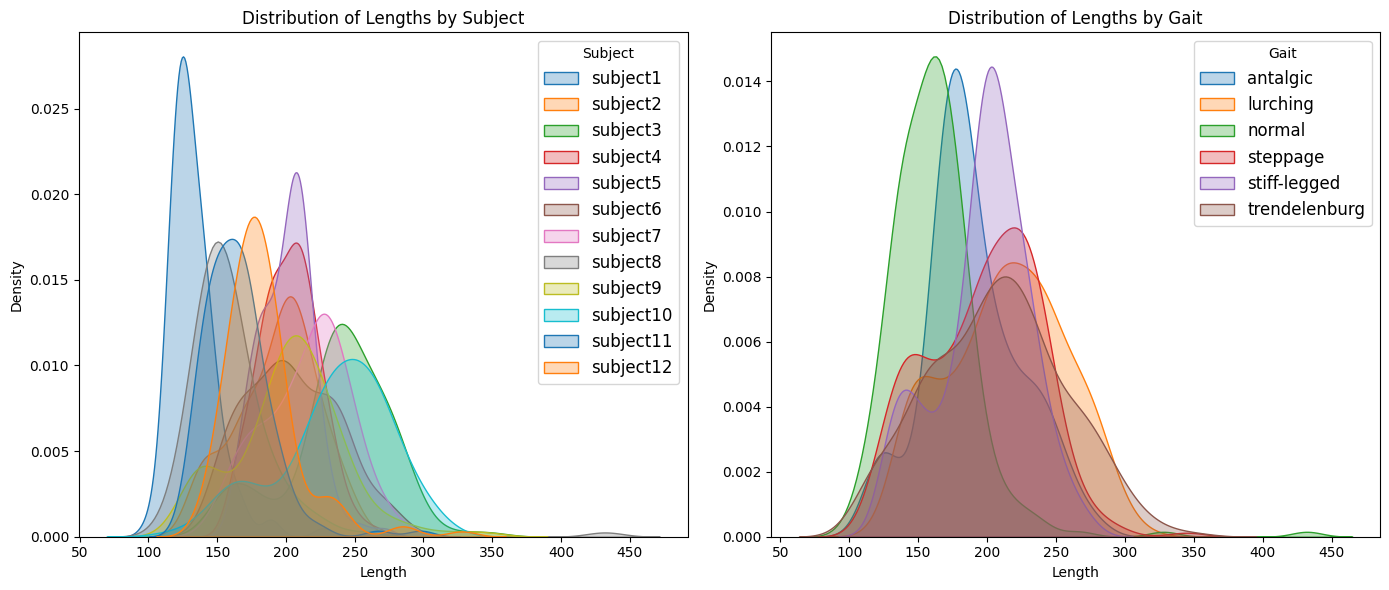

In [44]:
all_lengths = reference_df[~reference_df.index.str.contains('flipped')].copy()
all_lengths['length'] = all_lengths.apply(lambda x: load_data_sk(x.name, clean_data=True).shape[0], axis=1)
all_lengths['gait'] = all_lengths['label'].map(_c.reversed_convrt_gait_dict) # to deal with gaits names and not the numeric encoding

plot_len_distrib(df_lengths=all_lengths)


Now we will do the same but without cleaning data

Maximum value is 509 for subject=subject8
Minimum value is 118 for subject=subject1

Maximum value is 509 for gait=normal
Minimum value is 118 for gait=normal



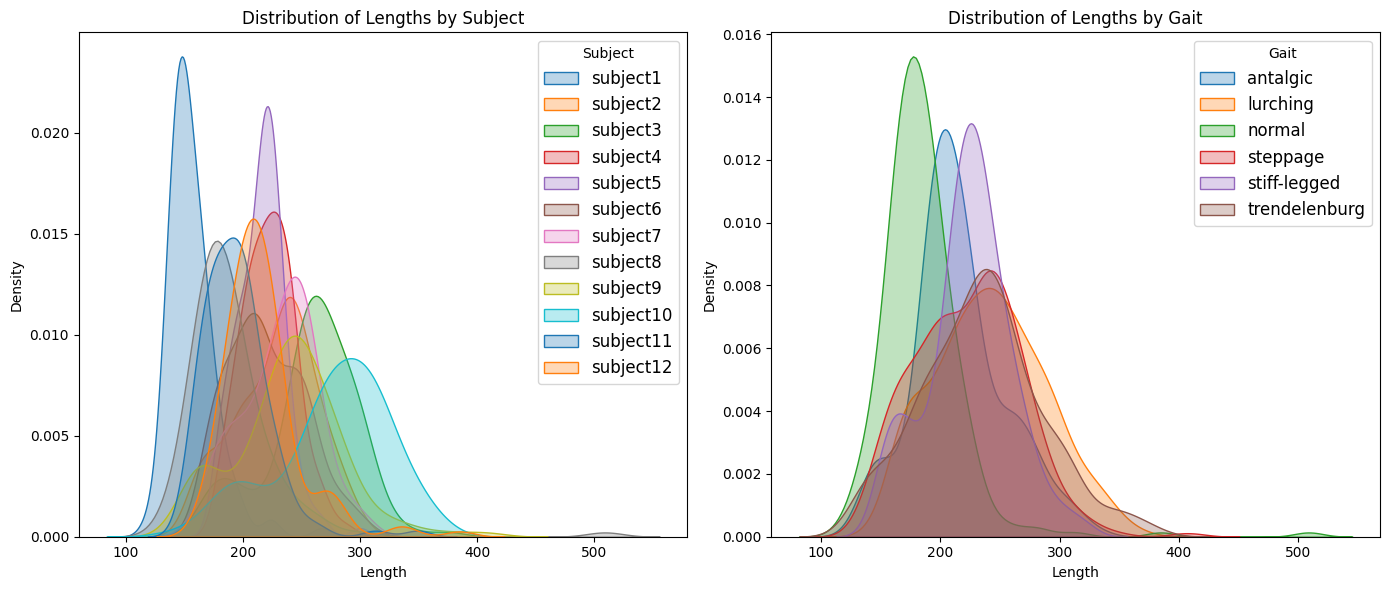

In [45]:
all_lengths1 = reference_df[~reference_df.index.str.contains('flipped')].copy()
all_lengths1['length'] = all_lengths1.apply(lambda x: load_data_sk(x.name, clean_data=False).shape[0], axis=1)
all_lengths1['gait'] = all_lengths1['label'].map(_c.reversed_convrt_gait_dict)

plot_len_distrib(df_lengths=all_lengths1)


Another interest aspect could be to chek how many rows has been deleted (on average) from each skeleton data due to the 0 seconds tiem difference between
consecutive frames.

In [46]:
print(f"{(all_lengths1['length']-all_lengths['length']).mean():.2f}")


26.14


### 12.2 - Speed Data

In [47]:
def extract_joint_speed(
  path:str,
  joints:list=_c.joints_to_include,
  target_size:int=50,
  crop_type:str='aggressive_center',
  specific_joint:int=None
):
  data = load_data_speed(path)
  data = remove_joints(data, joints_to_include=joints, is_speed=True)
  data = crop_data(data=data, target_size=target_size, crop_type=crop_type)
  return data[:,specific_joint]

def extract_all_trials_joint_speed(
  reference_df=pd.DataFrame,
  joints:list=None,
  target_size:int=50,
  crop_type:str='aggressive_center',
  specific_joint:int=None,
):
  all_speeds = pd.DataFrame(index=range(50))

  for path in reference_df.index:
    subj, gait, trial = path.split('/')[3], path.split('/')[4], path.split('/')[5]
    all_speeds[f'{subj}_{gait}_{trial}'] = extract_joint_speed(path, joints, target_size, crop_type, specific_joint)
  return all_speeds


In [48]:
def plot_speed_distrib_by_joint(
  reference_df:pd.DataFrame,
  joints_to_include:list=_c.joints_to_include,
  joint_names:list=_c.joint_names,
  convrt_gait_dict:dict=_c.convrt_gait_dict,
  target_size:int=50,
  crop_type:str='aggressive_center',
):
  joints_to_include_names = [joint_names[i] for i in joints_to_include]
  NUM_JOINTS = len(joints_to_include)
  gait_labels = list(convrt_gait_dict.keys())
  colors = sns.color_palette("husl", len(gait_labels))
  x_positions = np.arange(len(gait_labels)) * 2

  fig, axes = plt.subplots(4, 4, figsize=(20, 20))
  axes = axes.flatten()

  for joint_idx, joint in enumerate(joints_to_include):
    all_speeds = extract_all_trials_joint_speed(
      reference_df=reference_df[~reference_df.index.str.contains('flipped')].copy(),
      joints=joints_to_include,
      target_size=target_size,
      crop_type=crop_type,
      specific_joint=joint_idx)

    all_means_speed = pd.DataFrame()
    for gait in gait_labels:
      col_gait = [col for col in all_speeds.columns if gait in col]
      speed_gait = all_speeds[col_gait]
      all_means_speed[gait] = speed_gait.mean(axis=1)

    ax = axes[joint_idx]
    melted_means = all_means_speed.melt(var_name='Gait', value_name='MeanSpeed')

    for i, (gait, color) in enumerate(zip(gait_labels, colors)):
      values = melted_means[melted_means['Gait'] == gait]['MeanSpeed'].dropna()
      kde = gaussian_kde(values, bw_method=0.3)
      y_vals = np.linspace(values.min(), values.max(), 200)
      x_vals = kde(y_vals)
      x_shifted = x_positions[i] + x_vals
      ax.fill_betweenx(y_vals, x_positions[i], x_shifted, color=color, alpha=0.6, linewidth=1.5)
      ax.plot(x_shifted, y_vals, color=color, lw=2)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(gait_labels, rotation=45)
    ax.set_title(joints_to_include_names[joint_idx])
    ax.set_ylabel('Mean Speed')
    ax.set_xlabel('')

  for i in range(NUM_JOINTS, len(axes)):
    fig.delaxes(axes[i])

  fig.suptitle("Distribution of Mean Speed per Gait (Per Joint)", fontsize=18)
  plt.tight_layout(rect=[0, 0, 1, 0.97])
  plt.show()


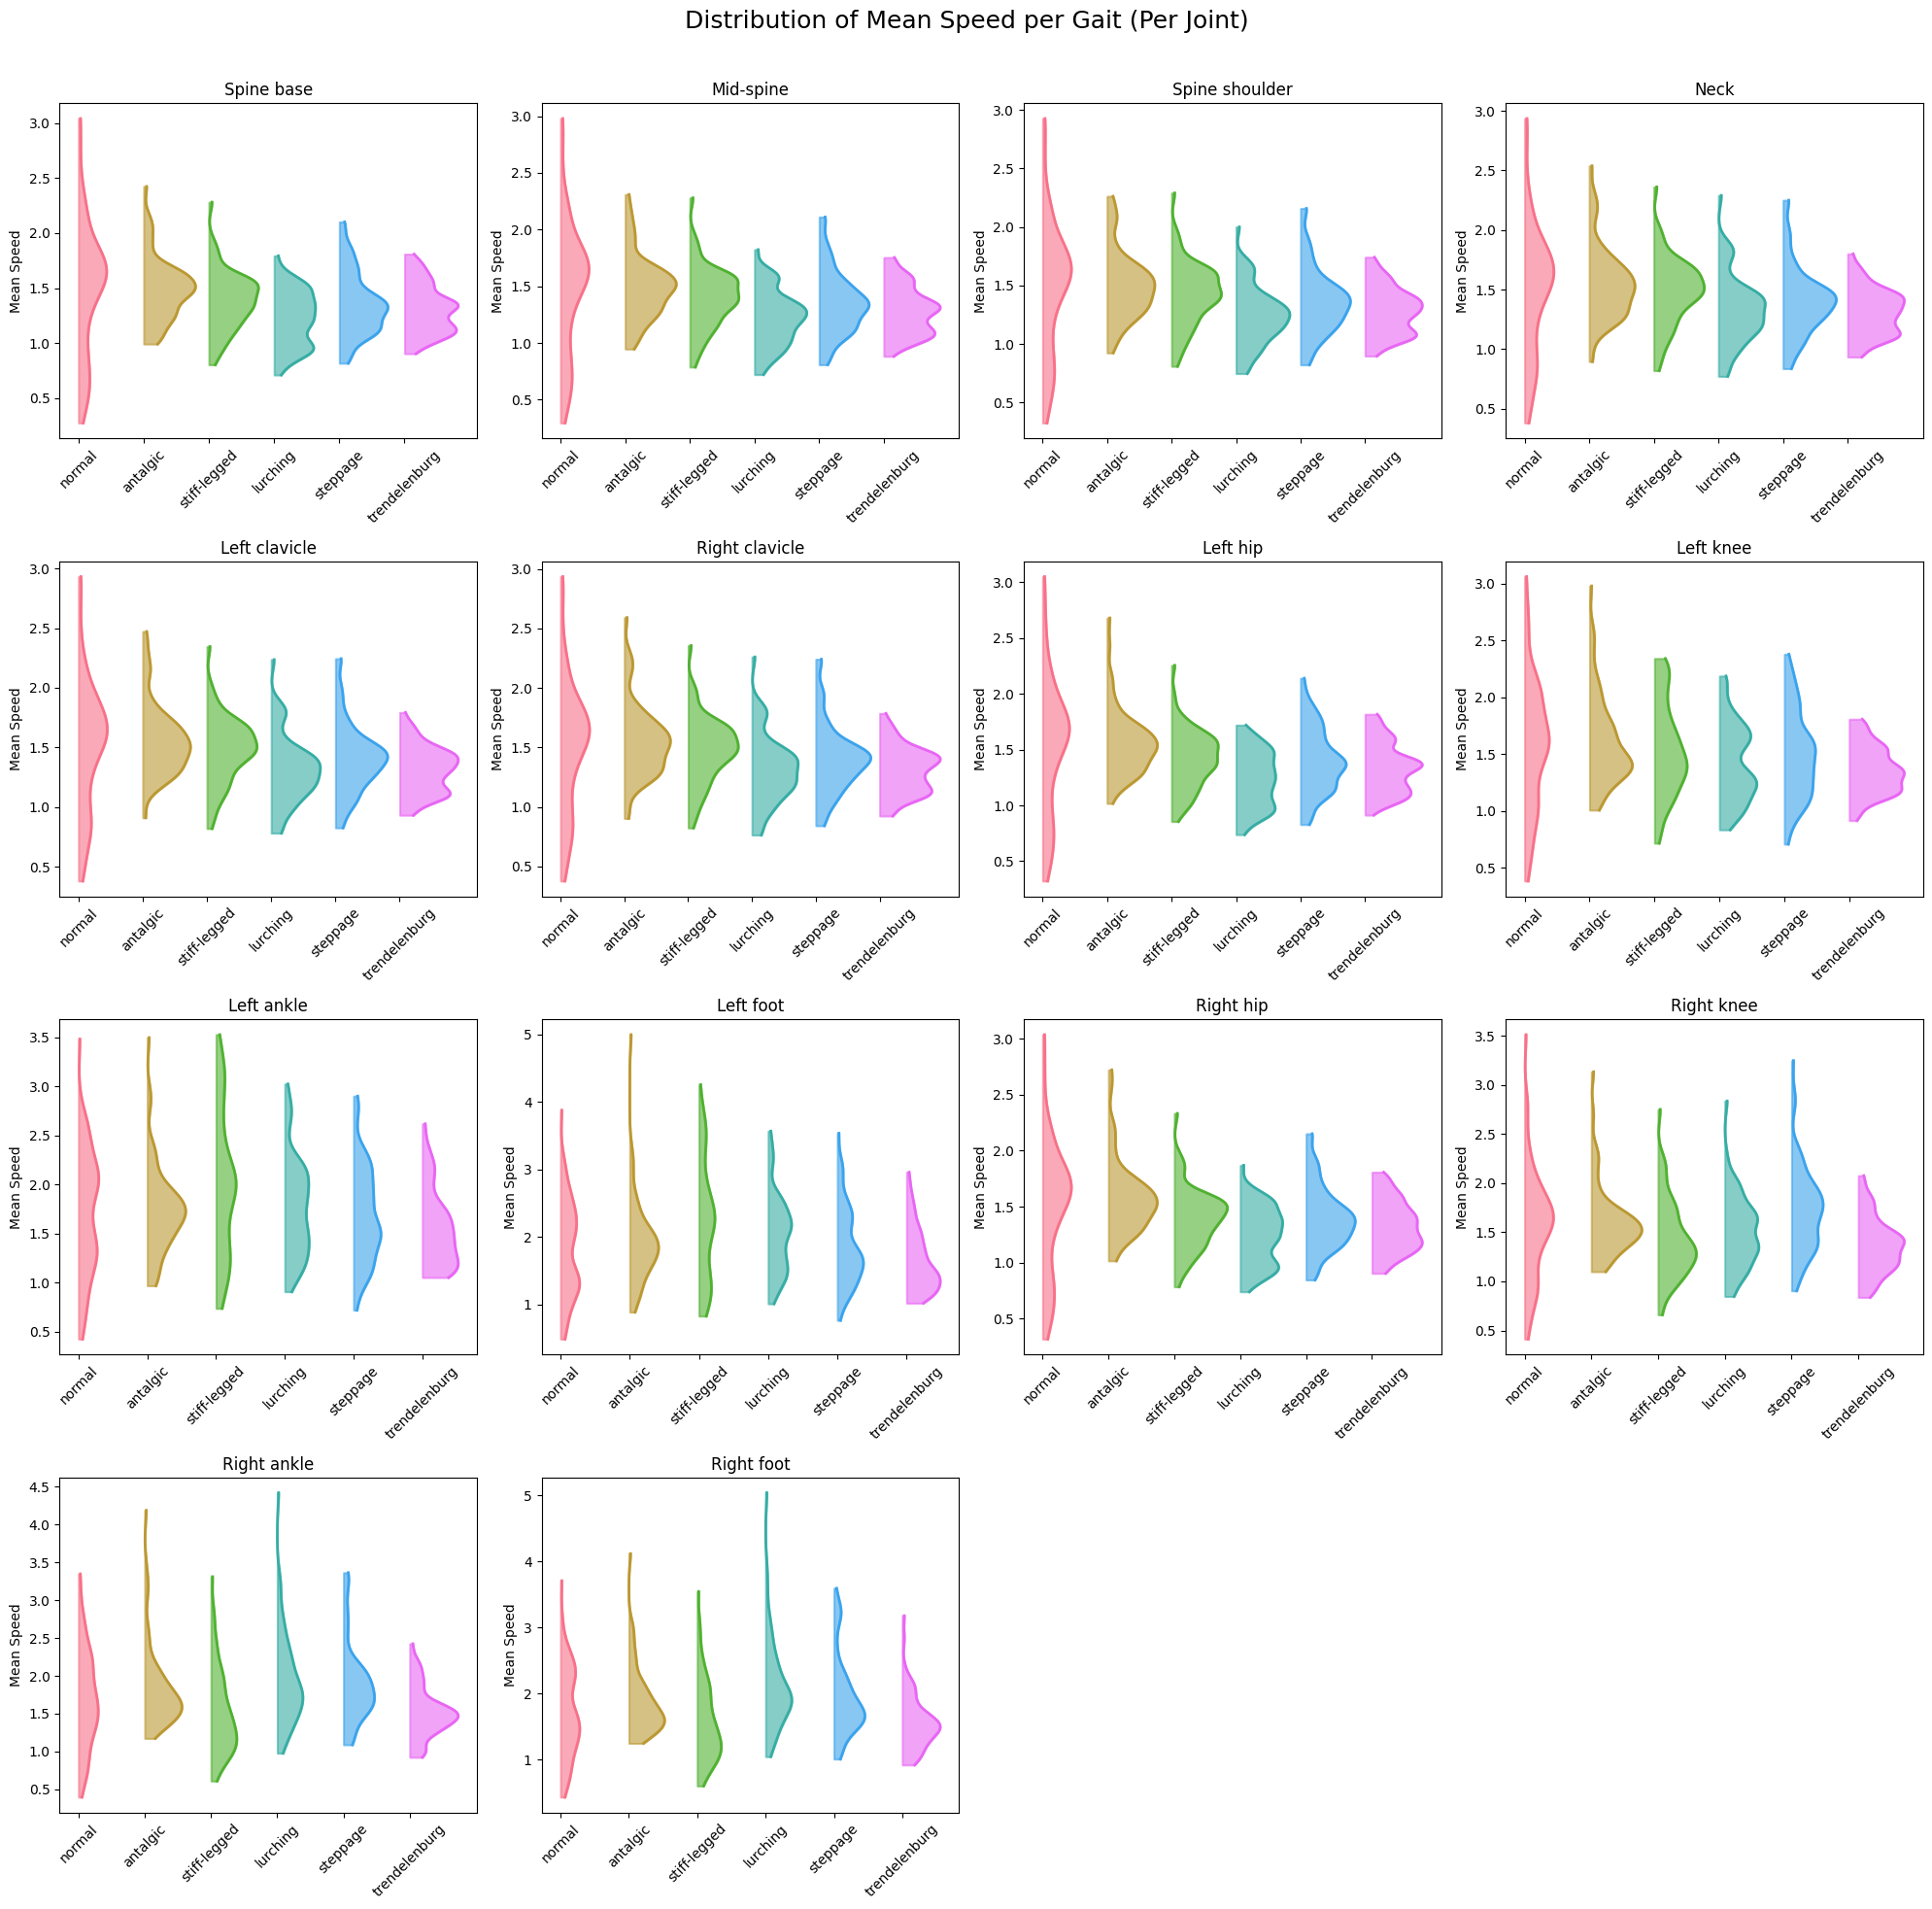

In [49]:
plot_speed_distrib_by_joint(reference_df=reference_df) #~3min
